### Systematic comparison of topics across conditions using quantitative similarity measurement

We calculate the semantic similarity between the topics from the two conditions directly from the sentence embedding

1. Create a Single "Topic Vector": For each topic in both HS and DL, calculate its average vector. We do this by taking the sentence embeddings of all sentences assigned to that topic and averaging them. This gives a single vector that represents the semantic center of that topic.

2. Calculate Cosine Similarity: Use cosine similarity to measure the angle between each HS topic vector and each DL topic vector. The output will be a score between 0 and 1*, where 1 means they are semantically identical.

3. Visualise with a Heatmap: Place the HS topics on the Y-axis and the DL topics on the X-axis. The colour of each cell would represent the cosine similarity score between the two topics.



* (with modern sentence embeddings, instead of -1 to 1). This happens because of how models are trained (designed to place sentences with similar meanings closer in the vector space, so vectors they produce tend to exist in the "first quadrant" of the high-dimensional space ie  most of their component values are positive).

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity


import os,sys 
# current_dir = os.getcwd()
# project_root = os.path.dirname(current_dir)  
# sys.path.append(project_root)

current_dir = os.getcwd()
project_root = os.path.abspath(os.path.join(current_dir, '..', '../..'))  # goes two levels up to MOSAIC
print("Project root:",project_root)
sys.path.append(project_root)
from configs.dreamachine2 import config



dataset = 'dreamachine'
results_dir = os.path.join(project_root, "EVAL",dataset.lower())
topic_content_HS = pd.read_csv(os.path.join(results_dir, f"topics_content/topic_content_HS_final.csv"))
topic_content_DL = pd.read_csv(os.path.join(results_dir, f"topics_content/topic_content_DL_final.csv"))

Project root: /Users/rb666/Projects/MOSAIC


In [2]:
list(topic_content_HS.Topic_Label)

['Vivid Geometric Patterns and Colors in Visual Phenomena',
 'Out-of-Body Experiences and Cosmic Consciousness',
 'Unlabelled',
 'Time-Space Portal Dynamics and Perceptual Experience',
 'Mindfulness-Based Sensory Experience for Calm and Peace',
 'Psychological Experience of Euphoric Relaxation',
 'Subjective Experience of Therapeutic Potential',
 'Nostalgic Flashbacks and Sensory Experiences',
 'Synesthetic Emotional Experience',
 'Photic Stimulation Effects on Visual Perception and Anxiety',
 'Subjective Experience of Sensory Overload and Anxiety',
 'Psychedelic Experience and Potential for Trauma Processing',
 'Near-Death Experience and Existential Reflections']

In [3]:
list(topic_content_DL.Topic_Label)

['Mindfulness and Relaxation Through Sound Experience',
 'Spiritual Experiences of Connection and Self-Discovery',
 'Phenomenology of Visual Perception in Closed Eyes',
 'Imagery and Perception of Aquatic Environments',
 'Out-of-Body Experience',
 'Outlier',
 'Space-Time Imagery and Perception',
 'The Power of Music on Spatial Perception']

# Method 1

In [4]:
df_hs = topic_content_HS
df_dl = topic_content_DL

hs_counts = df_hs.set_index('Topic_Label')['Sentence_Count'].rename('HS')
dl_counts = df_dl.set_index('Topic_Label')['Sentence_Count'].rename('DL')

contingency_table = pd.concat([hs_counts, dl_counts], axis=1).fillna(0).astype(int)

if 'Outlier' in contingency_table.index:
    contingency_table = contingency_table.drop('Outlier')

if 'Unlabelled' in contingency_table.index:
    contingency_table = contingency_table.drop('Unlabelled')

print("\n--- Contingency Table (Observed Frequencies) ---")
print(contingency_table)
print("-------------------------------------------------")


--- Contingency Table (Observed Frequencies) ---
                                                     HS  DL
Topic_Label                                                
Vivid Geometric Patterns and Colors in Visual P...  191   0
Out-of-Body Experiences and Cosmic Consciousness    125   0
Time-Space Portal Dynamics and Perceptual Exper...   58   0
Mindfulness-Based Sensory Experience for Calm a...   54   0
Psychological Experience of Euphoric Relaxation      40   0
Subjective Experience of Therapeutic Potential       33   0
Nostalgic Flashbacks and Sensory Experiences         29   0
Synesthetic Emotional Experience                     27   0
Photic Stimulation Effects on Visual Perception...   24   0
Subjective Experience of Sensory Overload and A...   24   0
Psychedelic Experience and Potential for Trauma...   14   0
Near-Death Experience and Existential Reflections    13   0
Mindfulness and Relaxation Through Sound Experi...    0  50
Spiritual Experiences of Connection and Self-Di...

# Method 2

In [5]:
# Convert topic_content_HS to the same structure as hs_df
hs_df_full = topic_content_HS.explode('Content').reset_index(drop=True)
# If 'Content' is a string representation of a list, eval it first
if isinstance(hs_df_full.loc[0, 'Content'], str):
    hs_df_full = topic_content_HS.copy()
    hs_df_full['Content'] = hs_df_full['Content'].apply(eval)
    hs_df_full = hs_df_full.explode('Content').reset_index(drop=True)
hs_df_full = hs_df_full.rename(columns={'Topic_Label': 'topic', 'Content': 'text'})
hs_df_full = hs_df_full[['topic', 'text']]

# Convert topic_content_DL to the same structure as dl_df
dl_df_full = topic_content_DL.copy()
dl_df_full['Content'] = dl_df_full['Content'].apply(eval)
dl_df_full = dl_df_full.explode('Content').reset_index(drop=True)
dl_df_full = dl_df_full.rename(columns={'Topic_Label': 'topic', 'Content': 'text'})
dl_df_full = dl_df_full[['topic', 'text']]

print(hs_df_full.head())
print(dl_df_full.head())

                                               topic  \
0  Vivid Geometric Patterns and Colors in Visual ...   
1  Vivid Geometric Patterns and Colors in Visual ...   
2  Vivid Geometric Patterns and Colors in Visual ...   
3  Vivid Geometric Patterns and Colors in Visual ...   
4  Vivid Geometric Patterns and Colors in Visual ...   

                                                text  
0  A pattern of red and white lights that flashed...  
1                                   Hope as a color.  
2                 Incredible technicolor experience.  
3  At one point, the light darkened and my vision...  
4                    Incredible colors and patterns.  
                                               topic  \
0  Mindfulness and Relaxation Through Sound Exper...   
1  Mindfulness and Relaxation Through Sound Exper...   
2  Mindfulness and Relaxation Through Sound Exper...   
3  Mindfulness and Relaxation Through Sound Exper...   
4  Mindfulness and Relaxation Through Sound Exper... 

### Generate sentence embeddings

In [6]:
# Load a pre-trained model
model = SentenceTransformer(config.transformer_model)
print(f"\n--- Loaded SentenceTransformer Model: {config.transformer_model} ---")

# # Generate embeddings for each dataset
hs_df_full['embedding'] = list(model.encode(hs_df_full['text']))
dl_df_full['embedding'] = list(model.encode(dl_df_full['text']))

print("\n--- Sentence Embeddings Generated ---")
print("Embeddings have been added as a new column to the DataFrames.")


--- Loaded SentenceTransformer Model: Qwen/Qwen3-Embedding-0.6B ---

--- Sentence Embeddings Generated ---
Embeddings have been added as a new column to the DataFrames.


In [7]:
# Filter out the 'Outlier' topic from both dataframes before grouping
# hs_df_filtered = hs_df_full[hs_df_full['topic'] != 'Outlier']
hs_df_filtered = hs_df_full[hs_df_full['topic'] != 'Unlabelled']
dl_df_filtered = dl_df_full[dl_df_full['topic'] != 'Outlier']

# We group by topic and calculate the average embedding for that topic.
hs_topic_vectors = hs_df_filtered.groupby('topic')['embedding'].apply(np.mean)
dl_topic_vectors = dl_df_filtered.groupby('topic')['embedding'].apply(np.mean)


print("\n--- Topic Vectors Created (Outliers Removed) ---")
print("HS Topics:")
print(hs_topic_vectors.index.tolist())
print("\nDL Topics:")
print(dl_topic_vectors.index.tolist())


--- Topic Vectors Created (Outliers Removed) ---
HS Topics:
['Mindfulness-Based Sensory Experience for Calm and Peace', 'Near-Death Experience and Existential Reflections', 'Nostalgic Flashbacks and Sensory Experiences', 'Out-of-Body Experiences and Cosmic Consciousness', 'Photic Stimulation Effects on Visual Perception and Anxiety', 'Psychedelic Experience and Potential for Trauma Processing', 'Psychological Experience of Euphoric Relaxation', 'Subjective Experience of Sensory Overload and Anxiety', 'Subjective Experience of Therapeutic Potential', 'Synesthetic Emotional Experience', 'Time-Space Portal Dynamics and Perceptual Experience', 'Vivid Geometric Patterns and Colors in Visual Phenomena']

DL Topics:
['Imagery and Perception of Aquatic Environments', 'Mindfulness and Relaxation Through Sound Experience', 'Out-of-Body Experience', 'Phenomenology of Visual Perception in Closed Eyes', 'Space-Time Imagery and Perception', 'Spiritual Experiences of Connection and Self-Discovery', 

### Calculate Cosine Similarity Between HS and DL Topics

In [8]:
# Create a matrix to store the similarity scores
similarity_matrix = pd.DataFrame(index=hs_topic_vectors.index, columns=dl_topic_vectors.index)

# Loop through each pair of topics and calculate their similarity
for hs_topic, hs_vector in hs_topic_vectors.items():
    for dl_topic, dl_vector in dl_topic_vectors.items():
        # Reshape vectors for the function
        sim_score = cosine_similarity(hs_vector.reshape(1, -1), dl_vector.reshape(1, -1))
        similarity_matrix.loc[hs_topic, dl_topic] = sim_score[0, 0]

# Convert the matrix to float type for the heatmap
similarity_matrix = similarity_matrix.astype(float)

print("\n--- Cosine Similarity Matrix ---")
print(similarity_matrix)



--- Cosine Similarity Matrix ---
topic                                               Imagery and Perception of Aquatic Environments  \
topic                                                                                                
Mindfulness-Based Sensory Experience for Calm a...                                        0.697538   
Near-Death Experience and Existential Reflections                                         0.720553   
Nostalgic Flashbacks and Sensory Experiences                                              0.781721   
Out-of-Body Experiences and Cosmic Consciousness                                          0.870808   
Photic Stimulation Effects on Visual Perception...                                        0.761447   
Psychedelic Experience and Potential for Trauma...                                        0.670985   
Psychological Experience of Euphoric Relaxation                                           0.818240   
Subjective Experience of Sensory Overload and A.


--- Generating Heatmap ---


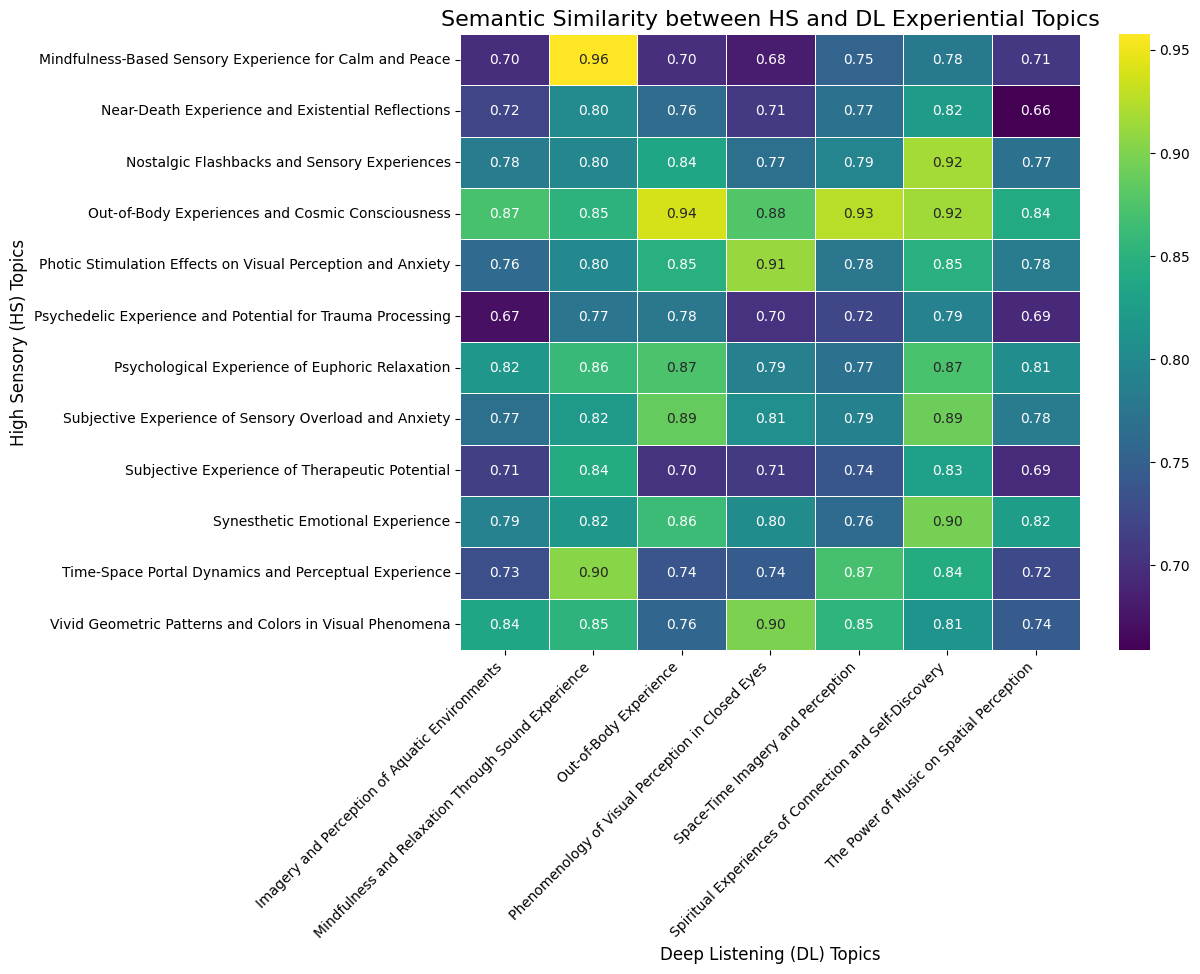

In [9]:
print("\n--- Generating Heatmap ---")

plt.figure(figsize=(10, 8))
sns.heatmap(
    similarity_matrix,
    annot=True,          # Show the similarity scores in each cell
    cmap='viridis',      # Use a color-friendly palette
    linewidths=.5,
    fmt=".2f"            # Format scores to two decimal places
)
plt.title('Semantic Similarity between HS and DL Experiential Topics', fontsize=16)
plt.xlabel('Deep Listening (DL) Topics', fontsize=12)
plt.ylabel('High Sensory (HS) Topics', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.show()



In [10]:
# Find all pairs of topics (HS, DL) with cosine similarity >= 0.9
pairs_to_merge = []
for hs_topic in similarity_matrix.index:
    for dl_topic in similarity_matrix.columns:
        if similarity_matrix.loc[hs_topic, dl_topic] > 0.9:
            pairs_to_merge.append((hs_topic, dl_topic))

# Build a mapping: each topic label (HS or DL) -> merged group name
# We'll use a simple naming: join the two topic names with ' / '
merge_map = {}
for hs_topic, dl_topic in pairs_to_merge:
    merged_name = f"{hs_topic} / {dl_topic}"
    merge_map[hs_topic] = merged_name
    merge_map[dl_topic] = merged_name

# For topics not in any merge, keep their original name
for topic in contingency_table.index:
    if topic not in merge_map:
        merge_map[topic] = topic

# Apply the mapping to create a new merged topic column
contingency_table_merged = contingency_table.copy()
contingency_table_merged['Merged_Topic'] = contingency_table_merged.index.map(merge_map)

# Group by merged topic and sum counts
contingency_table_merged = contingency_table_merged.groupby('Merged_Topic')[['HS', 'DL']].sum()

print("--- Merged Contingency Table (>= 0.9 similarity) ---")
print(contingency_table_merged)

--- Merged Contingency Table (>= 0.9 similarity) ---
                                                     HS  DL
Merged_Topic                                               
Imagery and Perception of Aquatic Environments        0  19
Mindfulness-Based Sensory Experience for Calm a...   54   0
Near-Death Experience and Existential Reflections    13   0
Nostalgic Flashbacks and Sensory Experiences / ...   29   0
Out-of-Body Experiences and Cosmic Consciousnes...    0  16
Out-of-Body Experiences and Cosmic Consciousnes...    0  15
Out-of-Body Experiences and Cosmic Consciousnes...  125  41
Photic Stimulation Effects on Visual Perception...   24  27
Psychedelic Experience and Potential for Trauma...   14   0
Psychological Experience of Euphoric Relaxation      40   0
Subjective Experience of Sensory Overload and A...   24   0
Subjective Experience of Therapeutic Potential       33   0
Synesthetic Emotional Experience                     27   0
The Power of Music on Spatial Perception       

# Method 1.2 (1 after 2)

In [11]:
import pandas as pd
import numpy as np

# --- Step 1: Define a new, cleaner mapping based on the heatmap ---
# Here, we define concise new names for the merged themes.
# The keys are the original topic labels, and the values are the new theme names.
# You can adjust the new theme names as you see fit.

merged_topic_map = {
    # Mindfulness Theme (Similarity: 0.96)
    'Mindfulness and Music Based Sensory Experience for Calm and Peace': 'Sound inducing Mindfulness & Relaxation', #HS
    'Mindfulness and Relaxation Through Sound Experience': 'Sound inducing Mindfulness & Relaxation', #DL
    
    # Altered States Theme (Similarities: 0.94, 0.93)
    'Out-of-Body Experiences and Cosmic Dream-Like Consciousness': 'Altered States of Consciousness (OBE, Space-Time)', #HS
    'Out-of-Body Experience': 'Altered States of Consciousness (OBE, Space-Time)', #DL
    'Imaginary Space-Time Experiences and Phenomenological States': 'Altered States of Consciousness (OBE, Space-Time)', #DL
    'Experience of Time and Space Distortions': 'Altered States of Consciousness (OBE, Space-Time)', #HS
    
    # Visual Phenomena Theme (Similarities: 0.91, 0.90)
    'Visual Perception of Kaleidoscopic Patterns and Colors': 'Direct Visual Phenomena',
    'Visual Sensitivity to Flashing Light Intensity': 'Direct Visual Phenomena', #HS
    'Phenomenology of Visual Perception in Closed Eyes': 'Direct Visual Phenomena', #DL

    # Introspective/Spiritual Theme (Similarities: 0.92, 0.90)
    'Nostalgic Memory Recall Phenomenon': 'Introspective & Spiritual States', #HS
    'Synesthetic Sensory and Emotional Experience': 'Introspective & Spiritual States',
    'Spiritual Experiences of Connection and Self-Discovery': 'Introspective & Spiritual States' #DL
}

# --- Step 2: Prepare your dataframes ---
# (Assuming your original data is in 'topic_content_HS' and 'topic_content_DL')

# Explode the sentences from the 'Content' column (handle string-list format)
topic_content_hs_copy = topic_content_HS.copy()
topic_content_hs_copy['Content'] = topic_content_hs_copy['Content'].apply(eval)
hs_sentences_df = topic_content_hs_copy.explode('Content').rename(columns={'Topic_Label': 'Original_Topic'})
hs_sentences_df['Condition'] = 'HS'

topic_content_dl_copy = topic_content_DL.copy()
topic_content_dl_copy['Content'] = topic_content_dl_copy['Content'].apply(eval)
dl_sentences_df = topic_content_dl_copy.explode('Content').rename(columns={'Topic_Label': 'Original_Topic'})
dl_sentences_df['Condition'] = 'DL'


# --- Step 3: Apply the cleaner mapping ---

# Combine the dataframes into one
all_sentences_df = pd.concat([hs_sentences_df, dl_sentences_df], ignore_index=True)

# Create a new 'Merged_Topic' column. 
# It uses the new name if the topic is in the map, otherwise it keeps the original name.
all_sentences_df['Merged_Topic'] = all_sentences_df['Original_Topic'].map(merged_topic_map)
all_sentences_df['Merged_Topic'].fillna(all_sentences_df['Original_Topic'], inplace=True)


# --- Step 4: Create the final contingency table ---
# This is a much simpler way to get the final table.

# Group by the new merged topic and the condition, then count the sentences
contingency_table = all_sentences_df.groupby(['Merged_Topic', 'Condition']).size().unstack(fill_value=0)

# Reorder columns to be HS then DL for consistency
contingency_table = contingency_table[['HS', 'DL']]

# Filter out the 'Unlabelled' topic if it exists
if 'Unlabelled' in contingency_table.index:
    contingency_table = contingency_table.drop('Unlabelled')

if 'Outlier' in contingency_table.index:
    contingency_table = contingency_table.drop('Outlier')

print("--- New Merged Contingency Table ---")
print(contingency_table)

--- New Merged Contingency Table ---
Condition                                            HS  DL
Merged_Topic                                               
Altered States of Consciousness (OBE, Space-Time)     0  16
Direct Visual Phenomena                               0  27
Imagery and Perception of Aquatic Environments        0  19
Introspective & Spiritual States                      0  41
Mindfulness-Based Sensory Experience for Calm a...   54   0
Near-Death Experience and Existential Reflections    13   0
Nostalgic Flashbacks and Sensory Experiences         29   0
Out-of-Body Experiences and Cosmic Consciousness    125   0
Photic Stimulation Effects on Visual Perception...   24   0
Psychedelic Experience and Potential for Trauma...   14   0
Psychological Experience of Euphoric Relaxation      40   0
Sound inducing Mindfulness & Relaxation               0  50
Space-Time Imagery and Perception                     0  15
Subjective Experience of Sensory Overload and A...   24   0
Sub

/var/folders/1d/q_0fy53s0jdcsc1sb09wkntw00z7v7/T/ipykernel_68455/825766719.py:54: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  all_sentences_df['Merged_Topic'].fillna(all_sentences_df['Original_Topic'], inplace=True)


--- Chi-Squared Test Results ---
Chi-squared statistic (χ²): 408.28
Degrees of Freedom (dof): 15
P-value: 0.0000

--- Interpretation ---
The p-value (0.0000) is less than 0.05, indicating a statistically significant association
between the condition (HS/DL) and the experiential themes reported.


--- Generating Final Bar Chart ---

Chart saved as topic_frequency_comparison.png


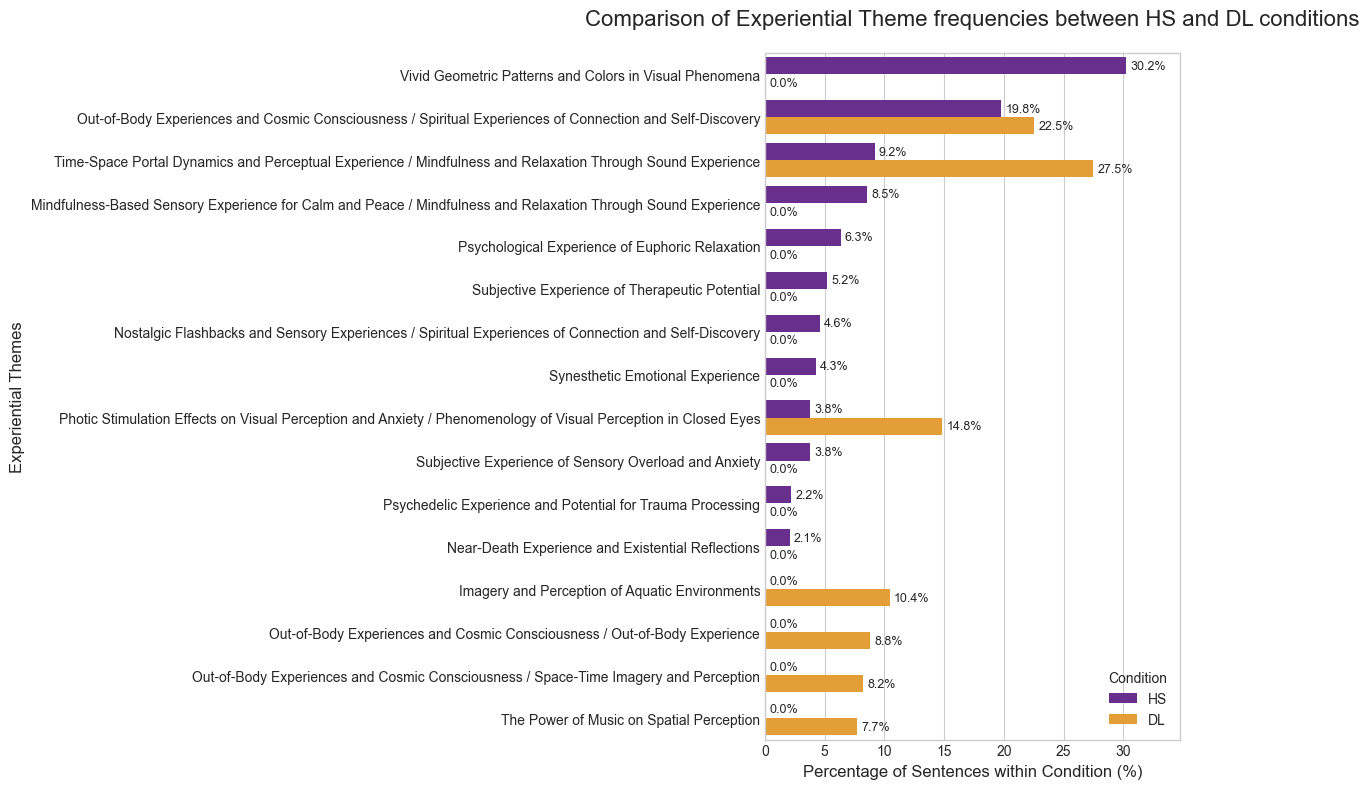

In [12]:
import pandas as pd
import numpy as np
from scipy.stats import chi2_contingency
import matplotlib.pyplot as plt
import seaborn as sns

# Assume 'contingency_table' is the final DataFrame from the previous step.

# --- Step 1: Perform the Chi-Squared Test ---

chi2, p_value, dof, expected = chi2_contingency(contingency_table_merged)

print("--- Chi-Squared Test Results ---")
print(f"Chi-squared statistic (χ²): {chi2:.2f}")
print(f"Degrees of Freedom (dof): {dof}")
print(f"P-value: {p_value:.4f}")

# --- Interpretation ---
print("\n--- Interpretation ---")
alpha = 0.05
if p_value < alpha:
    print(f"The p-value ({p_value:.4f}) is less than {alpha}, indicating a statistically significant association")
    print("between the condition (HS/DL) and the experiential themes reported.")
else:
    print(f"The p-value ({p_value:.4f}) is not less than {alpha}, indicating no statistically significant association.")
print("\n" + "="*50 + "\n")


# --- Step 2: Create the Comparative Bar Chart ---

print("--- Generating Final Bar Chart ---")

# Calculate percentages within each condition to normalise for sample size
percentage_table = contingency_table_merged.div(contingency_table_merged.sum(axis=0), axis=1) * 100

# Sort the topics by the percentage in the HS condition for a clearer chart
sorted_order = percentage_table.sort_values(by='HS', ascending=False).index

# Prepare the data for plotting by "melting" the dataframe
plot_data = percentage_table.reset_index().melt(id_vars='Merged_Topic', var_name='Condition', value_name='Percentage')

# Create the plot
plt.style.use('seaborn-v0_8-whitegrid')
fig, ax = plt.subplots(figsize=(12, 8))

sns.barplot(
    data=plot_data,
    y='Merged_Topic',
    x='Percentage',
    hue='Condition',
    palette={'HS': "#6d1f9d", 'DL': "#ffa41c"},
    order=sorted_order,  # Use the sorted order for the y-axis
    ax=ax
)

# --- Formatting ---
ax.set_title('Comparison of Experiential Theme frequencies between HS and DL conditions', fontsize=16, pad=20)
ax.set_xlabel('Percentage of Sentences within Condition (%)', fontsize=12)
ax.set_ylabel('Experiential Themes', fontsize=12)
ax.tick_params(axis='y', labelsize=10)
ax.legend(title='Condition', loc='lower right')

# Add percentage labels to the bars for clarity
for container in ax.containers:
    ax.bar_label(container, fmt='%.1f%%', label_type='edge', fontsize=9, padding=3)

# Adjust x-axis limit to give space for labels
ax.set_xlim(0, percentage_table['HS'].max() * 1.15) # Set limit based on the max HS value

plt.tight_layout()

# Save the figure for your manuscript
plt.savefig("topic_frequency_comparison.png", dpi=300)
print("\nChart saved as topic_frequency_comparison.png")
plt.savefig("comparison_chart.pdf", format='pdf', bbox_inches='tight')

# Show the plot
plt.show()

In [13]:
# Calculate cosine similarity between all DL topics (intra-DL similarity)
dl_similarity_matrix = pd.DataFrame(index=dl_topic_vectors.index, columns=dl_topic_vectors.index)

for topic1, vec1 in dl_topic_vectors.items():
    for topic2, vec2 in dl_topic_vectors.items():
        sim_score = cosine_similarity(vec1.reshape(1, -1), vec2.reshape(1, -1))
        dl_similarity_matrix.loc[topic1, topic2] = sim_score[0, 0]

dl_similarity_matrix = dl_similarity_matrix.astype(float)

print("\n--- Cosine Similarity Matrix Between DL Topics ---")
print(dl_similarity_matrix)


--- Cosine Similarity Matrix Between DL Topics ---
topic                                               Imagery and Perception of Aquatic Environments  \
topic                                                                                                
Imagery and Perception of Aquatic Environments                                            1.000000   
Mindfulness and Relaxation Through Sound Experi...                                        0.782200   
Out-of-Body Experience                                                                    0.826771   
Phenomenology of Visual Perception in Closed Eyes                                         0.805149   
Space-Time Imagery and Perception                                                         0.825225   
Spiritual Experiences of Connection and Self-Di...                                        0.809409   
The Power of Music on Spatial Perception                                                  0.762853   

topic                        